# Clustering with Manual Similarity Measure

In this Colab, you will group chocolates in the
[Chocolate Bar Ratings](https://www.kaggle.com/rtatman/chocolate-bar-ratings)
dataset using the k-means clustering algorithm with a manual similarity measure. The dataset has ratings
of chocolate bars along with their cocoa percentage, bean type, bean origin,
maker name, and maker country. You will:

*   Load and clean the data.
*   Process the data.
*   Calculate similarity between pairs of chocolates.
*   Cluster the chocolates using k-means.
*   Check the clustering result using quality metrics.


# 1. Load and clean data

Run the following cell to load and clean the chocolate dataset. The first few rows of the dataset are displayed. Inspect
the features and their values.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nla
import pandas as pd
import tensorflow as tf
import seaborn as sns
import altair as alt
import re
import pdb # python debugger
import sys
from os.path import join

np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')

# We can rename the columns.
choc_data.columns = ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']

# choc_data.dtypes

In [2]:
choc_data.dtypes

maker                object
specific_origin      object
reference_number      int64
review_date           int64
cocoa_percent        object
maker_location       object
rating              float64
bean_type            object
broad_origin         object
dtype: object

In [3]:
# Replace empty/null values with "Blend"
choc_data['bean_type'] = choc_data['bean_type'].fillna('Blend')

# Cast bean_type to string to remove leading 'u'
choc_data['bean_type'] = choc_data['bean_type'].astype('str')
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

choc_data

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70.00,Austria,3.75,Blend,Peru
1791,Zotter,Congo,749,2011,65.00,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65.00,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62.00,Austria,3.25,Blend,India


In [4]:
# # Correct spelling mistakes, and replace city with country name
# choc_data['maker_location'] = choc_data['maker_location']\
# .str.replace('amsterdam', 'Holland')\
# .str.replace('U.K', 'England')\
# .str.replace('Niacragua', ' Nicaragua')\
# .str.replace('Domincan Republic', 'Dominican Republic')

In [5]:
choc_data['maker_location'] = choc_data['maker_location'].str.replace('amsterdam', 'Holland')
choc_data['maker_location'] = choc_data['maker_location'].str.replace('U.K', 'England')
choc_data['maker_location'] = choc_data['maker_location'].str.replace('Niacragua', 'Nicaragua')
choc_data['maker_location'] = choc_data['maker_location'].str.replace('Domincan Republic', 'Dominican Republic')

<ipython-input-5-c82a60bdfbf5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  choc_data['maker_location'] = choc_data['maker_location'].str.replace('U.K', 'England')


In [6]:
choc_data.loc[choc_data['maker_location'] == 'amsterdam', 'maker_location'] = 'Holland'
choc_data.loc[choc_data['maker_location'] == 'U.K', 'maker_location'] = 'England'
choc_data.loc[choc_data['maker_location'] == 'Niacragua', 'maker_location'] = 'Nicaragua'
choc_data.loc[choc_data['maker_location'] == 'Domincan Republic', 'maker_location'] = 'Dominican Republic'

In [7]:
# Adding this so that Holland and Netherlands map to the same country.
choc_data['maker_location'] = choc_data['maker_location'].str.replace('Holland', 'Netherlands')

In [8]:
def cleanup_spelling_abbrev(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

In [9]:
choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

<ipython-input-9-d18f9eb0563c>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)


In [10]:
# Cast specific_origin to string
choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

In [11]:
# Replace null-valued fields with the same value as for specific_origin
choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

In [12]:
# Clean up spelling mistakes and deal with abbreviations
choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

<ipython-input-12-b86e43333675>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)


In [13]:
# Change 'Trinitario, Criollo' to "Criollo, Trinitario"
# Check with choc_data['bean_type'].unique()
choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"

In [14]:
# Confirm
choc_data[choc_data['bean_type'].isin(['Trinitario, Criollo'])]

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin


In [15]:
# Fix chocolate maker names
choc_data.loc[choc_data['maker']=='Shattel','maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

In [16]:
# Save the original column names
original_cols = choc_data.columns.values

In [17]:
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


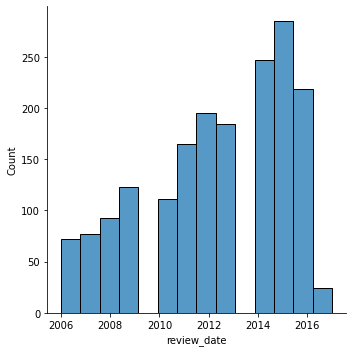

In [18]:
sns.displot(choc_data['review_date'])

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

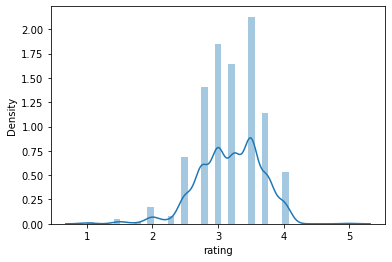

In [19]:
sns.distplot(choc_data['rating'])

In [20]:
choc_data['rating_norm'] = (choc_data['rating']-choc_data['rating'].mean())/choc_data['rating'].std()

In [21]:
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome,1.18
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cocoa_percent', ylabel='Density'>

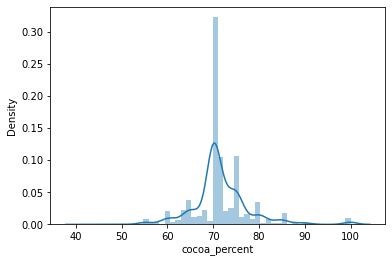

In [22]:
sns.distplot(choc_data['cocoa_percent'])

In [23]:
choc_data['cocoa_percent_norm'] = (choc_data['cocoa_percent'] - choc_data['cocoa_percent'].mean())/choc_data['cocoa_percent'].std()

In [24]:
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome,1.18,-1.38
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,-0.27
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,-0.27
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,-0.27
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,-0.27


 Run code to add latitude and longitude data
 Load lat long data

In [25]:
countries_info = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/countries_lat_long.csv", sep=",", encoding='latin-1')

In [26]:
countries_info.loc[countries_info['name'].str.contains('orea')]

,country,latitude,longitude,name
118,KP,40.34,127.51,North Korea
119,KR,35.91,127.77,South Korea


In [27]:
countries_info.loc[countries_info['name'].isin(['South Korea'])]

,country,latitude,longitude,name
119,KR,35.91,127.77,South Korea


Join the chocolate review and geographic information tables on maker country name

In [28]:
choc_data = pd.merge(choc_data, countries_info, left_on="maker_location", right_on="name")

#### pd.merge 정렬 기준(option)
on : (두 데이터프레임의 기준열 이름이 같을 때) 기준열 <br>
how : 조인 방식 {'left', 'right', 'inner', 'outer'} 기본값은 'inner' <br>
left_on : 기준열 이름이 다를 때, 왼쪽 기준열 <br>
right_on : 기준열 이름이 다를 때, 오른쪽 기준열

In [29]:
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm,country,latitude,longitude,name
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome,1.18,-1.38,FR,46.23,2.21,France
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,-0.27,FR,46.23,2.21,France
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,-0.27,FR,46.23,2.21,France
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,-0.27,FR,46.23,2.21,France
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,-0.27,FR,46.23,2.21,France


In [30]:
choc_data.rename(columns={"longitude": "maker_long","latitude": "maker_lat"}, inplace=True)
choc_data.drop(columns=["name", "country"], inplace=True)  # don't need this data

In [31]:
#Join the chocolate review and geographic information tables on origin country name
choc_data = pd.merge(choc_data, countries_info, left_on="broad_origin", right_on="name")
choc_data.rename(
    columns={ "longitude": "origin_long", "latitude": "origin_lat" }, inplace=True)

In [32]:
choc_data.drop(columns=["name", "country"], inplace=True)  # don't need this data

In [33]:
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long
0,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,-0.27,46.23,2.21,8.62,0.82
1,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,-0.27,46.23,2.21,8.62,0.82
2,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,-0.27,46.23,2.21,8.62,0.82
3,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,-0.27,46.23,2.21,-9.19,-75.02
4,A. Morin,Pablino,1319,2014,70.00,France,4.00,Blend,Peru,1.70,-0.27,46.23,2.21,-9.19,-75.02


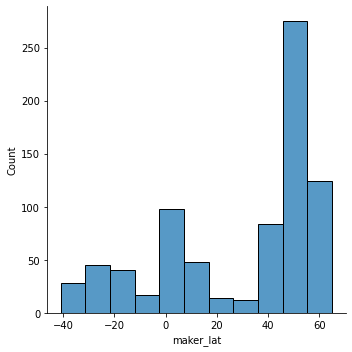

In [34]:
sns.displot(choc_data['maker_lat'])

Since latitude and longitude don't follow a specific distribution, 
convert the latitude and longitude information into quantiles. Display the last few rows to verify the quantile values.

In [35]:
numQuantiles = 20
colsQuantiles = ['maker_lat', 'maker_long', 'origin_lat', 'origin_long']

In [36]:
def createQuantiles(dfColumn, numQuantiles):
    return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')
# pd.qcut 은 전체합계를 20등분 (20개 각 구간의 갯수를 일정하게)
# pd.cut은 데이터 구간을 20개로 구분

In [37]:
for string in colsQuantiles:
    choc_data[string] = createQuantiles(choc_data[string], numQuantiles)

In [38]:
choc_data.tail()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long
780,Mesocacao,Honduras,1347,2014,70.00,Honduras,3.50,Blend,Honduras,0.66,-0.27,6,0,11,1
781,Malagos,"Davao,Mt Talamo foothills",1121,2013,65.00,Philippines,3.50,Trinitario,Philippines,0.66,-1.06,6,13,11,12
782,Mesocacao,El Salvador,1494,2015,80.00,Honduras,2.75,Blend,El Salvador,-0.91,1.31,6,0,11,0
783,Mesocacao,El Salvador,1494,2015,70.00,Honduras,3.00,Blend,El Salvador,-0.39,-0.27,6,0,11,0
784,Tan Ban Skrati,"Paramaribo,batch 20160043,01",1868,2016,70.00,Suriname,3.25,Trinitario,Suriname,0.13,-0.27,4,4,8,8


Quantile values range up to 20. Bring quantile values to the same scale as other feature data by scaling them to [0,1].

In [39]:
def minMaxScaler(numArr):
    minx = np.min(numArr)
    maxx = np.max(numArr)
    numArr = (numArr - minx) / (maxx - minx)
    return numArr

In [40]:
for string in colsQuantiles:
    choc_data[string] = minMaxScaler(choc_data[string])

The features `maker` and `bean_type` are categorical features. Convert
categorical features into one-hot encoding.

In [41]:
# duplicate the "maker" feature since it's removed by one-hot encoding function
choc_data['maker2'] = choc_data['maker']
choc_data = pd.get_dummies(choc_data, columns=['maker2'], prefix=['maker'])

In [42]:
# similarly, duplicate the "bean_type" feature
choc_data['bean_type2'] = choc_data['bean_type']
choc_data = pd.get_dummies(choc_data, columns=['bean_type2'], prefix=['bean'])

In [43]:
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,...,bean_Forastero (Arriba) ASSS,bean_Forastero (Catongo),bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA"
0,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,...,0,0,0,0,0,0,0,0,0,0
1,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,...,0,0,0,0,0,0,0,0,0,0
2,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,...,0,0,0,0,0,0,0,0,0,0
3,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,...,0,0,0,0,0,0,0,0,0,0
4,A. Morin,Pablino,1319,2014,70.00,France,4.00,Blend,Peru,1.70,...,0,0,0,0,0,0,0,0,0,0


After clustering, when you interpret the results, the processed feature data is
hard to read. Save the original feature data in a new dataframe so you can
reference it later. Keep only the processed data in `choc_data`.

In [44]:
# Split dataframe into two frames: Original data and data for clustering
choc_data_backup = choc_data.loc[:, original_cols].copy(deep=True)
choc_data.drop(columns=original_cols, inplace=True) # delete original columns

# get_dummies returned ints for one-hot encoding but we want floats so divide by 1.0
# Note: In the latest version of "get_dummies", you can set "dtype" to float
choc_data = choc_data/1.0

Inspect the last few records to ensure your precious chocolate data is looking
good! Remember that `choc_data` only shows columns with processed data because the columns holding the original data were moved to `choc_data_backup`.

In [45]:
choc_data.tail()

,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),...,bean_Forastero (Arriba) ASSS,bean_Forastero (Catongo),bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA"
780,0.66,-0.27,0.40,0.00,0.79,0.08,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
781,0.66,-1.06,0.40,0.87,0.79,0.92,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
782,-0.91,1.31,0.40,0.00,0.79,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
783,-0.39,-0.27,0.40,0.00,0.79,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
784,0.13,-0.27,0.27,0.27,0.57,0.62,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


# 3. Calculate Manual Similarity

Now calculating similarity between a
pair of chocolates is simple because all the features are numeric and in the
same range. For any two chocolates, simply find the root mean square error
(RMSE) of all features.

First run this code to define the similarity function.

In [46]:
def getSimilarity(obj1, obj2):
    len1 = len(obj1.index)
    len2 = len(obj2.index)
    if not (len1 == len2):
        print("Error: Compared objects must have same number of features.")
        sys.exit()
        return 0
    else:
        similarity = obj1 - obj2
        similarity = np.sum((similarity**2.0)/len1)
        similarity = 1 - math.sqrt(similarity)
        return similarity

In [47]:
a = getSimilarity(choc_data['maker_lat'], choc_data['origin_lat'])

Now calculate the similarity between the first chocolate and the next 4
chocolates. Verify the calculated similarity against your intuitive expectations
by comparing the calculated similarity to the actual feature data shown in the
next cell.

In [48]:
choc1 = 0  #@param
chocsToCompare = [1, 4]  #@param

print ("Similarity between chocolates " + str(choc1) + " and ...")

Similarity between chocolates 0 and ...


In [49]:
for ii in range(chocsToCompare[0], chocsToCompare[1] + 1):
  print (str(ii) + ": " + str(
      getSimilarity(choc_data.loc[choc1], choc_data.loc[ii])))

print ("\n\nFeature data for chocolate " + str(choc1))
print (choc_data_backup.loc[choc1:choc1, :])
print ("\n\nFeature data for compared chocolates " + str(chocsToCompare))
print (choc_data_backup.loc[chocsToCompare[0]:chocsToCompare[1], :])

1: 0.9655180745106698
2: 0.8965542235320095
3: 0.8870388506248589
4: 0.8217185589148988


Feature data for chocolate 0
      maker specific_origin  reference_number  review_date  cocoa_percent  \
0  A. Morin           Kpime              1676         2015          70.00   

  maker_location  rating bean_type broad_origin  
0         France    2.75     Blend         Togo  


Feature data for compared chocolates [1, 4]
      maker specific_origin  reference_number  review_date  cocoa_percent  \
1  A. Morin          Atsane              1676         2015          70.00   
2  A. Morin           Akata              1680         2015          70.00   
3  A. Morin          Quilla              1704         2015          70.00   
4  A. Morin         Pablino              1319         2014          70.00   

  maker_location  rating bean_type broad_origin  
1         France    3.00     Blend         Togo  
2         France    3.50     Blend         Togo  
3         France    3.50     Blend         P

# 4. Cluster Chocolate Dataset

We're ready to cluster the chocolates! Run the code to setup the k-means
clustering functions. You do not need to understand the code.

**Note**: If you're following the self study, then before running the rest of
this Colab, read the sections on
[k-means](https://developers.google.com/machine-learning/clustering/algorithm/run-algorithm)
and
[quality metrics](https://developers.google.com/machine-learning/clustering/interpret).
[what is norm?](http://taewan.kim/post/norm/)

In [50]:
# Run cell to setup functions
def dfSimilarity(df, centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
    numPoints = len(df.index)
    numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
    pointNorms = np.square(nla.norm(df, axis=1))
    pointNorms = np.reshape(pointNorms, [numPoints, 1])
  ## Calculate the norm of centroids
    centroidNorms = np.square(nla.norm(centroids, axis=1))
    centroidNorms = np.reshape(centroidNorms, (1,numCentroids))
    ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
    similarities = pointNorms + centroidNorms - 2.0 * np.dot(df, np.transpose(centroids))
  # Divide by the number of features Which is 10 because the one-hot encoding 
  # means the "Maker" and "Bean" are weighted twice  
    similarities = similarities / 10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
    similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
    similarities = np.sqrt(similarities)
    return similarities

numpy.clip(array, min, max) array 내의 element들에 대해서 <br>
    min 값 보다 작은 값들을 min값으로 바꿔주고&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ar1 = np.array([0, 1, 2, 3, 4, 5, 6, 7]) <br>
    max 값 보다 큰 값들을 max값으로 바꿔주는 함수   np.clip(ar1, 3, 5) => [3,3,3,3,4,5,5,5] 

In [51]:
def initCentroids(df, k, feature_cols): # centroid 선택: 비교할 columns를 기준으로 k개의 rows 임의로 선택
  # Pick 'k' examples are random to serve as initial centroids
    limit = len(df.index)
    centroids_key = np.random.randint(0, limit - 1, k)  # 임의의 k 선정
    centroids = df.loc[centroids_key, feature_cols].copy(deep=True) # k rows와 feature column으로 cnetroid 구성
  # the indexes get copied over so reset them
    centroids.reset_index(drop=True, inplace=True) # 기존 index 지우고, index를 0부터 일련번호 k-1까지로 재배열
    return centroids

y = f(x) 라고 할 때 <br>
max는 y가 최대인 값, argmax는 y를 최대가 되도록 하는 x <br>
min은 y가 최소인 값, argmin은 y를 최소가 되도록 하는 x 

In [52]:

def pt2centroid(df, centroids, feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
    numCentroids = len(centroids.index)
    numExamples = len(df.index)
    # dfSimilarity = Calculate similarities for dataframe input
    dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
    df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
    df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
    return df


def recomputeCentroids(df, centroids, feature_cols):
    ### For every centroid, recompute it as an average of the points
    ### assigned to it
    numCentroids = len(centroids.index)
    for cen in range(numCentroids):
        dfSubset = df.loc[df['centroid'] == cen,
                      feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
        clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
        centroids.loc[cen] = clusterAvg
    return centroids


def kmeans(df, k, feature_cols, verbose):
    flagConvergence = False
    maxIter = 100
    iter = 0  # ensure kmeans doesn't run for ever
    centroids = initCentroids(df, k, feature_cols)
    while not (flagConvergence):
        iter += 1
    #Save old mapping of points to centroids
        oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
        df = pt2centroid(df, centroids, feature_cols)
        centroids = recomputeCentroids(df, centroids, feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
        newMapping = df['centroid']
        flagConvergence = all(oldMapping == newMapping)
        if verbose == 1:
            print ('Total distance:' + str(np.sum(df['pt2centroid'])))
        if (iter > maxIter):
            print ('k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
        sys.exit()
        return
    print ('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
    return [df, centroids]

In [53]:
k = 30  #@param

feature_cols = choc_data.columns.values  # save original columns
# initialize every point to an impossible value, the k+1 cluster
choc_data['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
choc_data['pt2centroid'] = 2
[choc_data, centroids] = kmeans(choc_data, k, feature_cols, 1)
print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:')
choc_data.head()

Total distance:415.63801531484455


SystemExit: 

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [54]:
clusterNumber = 7  #@param
choc_data_backup.loc[choc_data['centroid'] == clusterNumber, :]

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
80,A. Morin,Chuao,1015,2013,70.00,France,4.00,Trinitario,Venezuela
86,Bonnat,Chuao,81,2006,75.00,France,4.00,Trinitario,Venezuela
113,Idilio (Felchlin),"Carenero Superior,Urrutia,Barlovento",737,2011,70.00,Switzerland,4.00,Trinitario,Venezuela
223,Bonnat,Madagascar,75,2006,75.00,France,4.00,Trinitario,Madagascar
237,East Van Roasters,Madagascar,1343,2014,70.00,Canada,3.50,Trinitario,Madagascar
...,...,...,...,...,...,...,...,...,...
531,Palette de Bine,Lam Dong,1574,2015,72.00,Canada,3.75,Trinitario,Vietnam
582,Hummingbird,Hispaniola,1311,2014,70.00,Canada,3.75,Trinitario,Dominican Republic
636,Sirene,Kokoa Kamili Coop,1856,2016,73.00,Canada,3.50,Blend,Tanzania
645,Omnom,"Kakao Kamili,Kilombero Valley",1816,2016,70.00,Iceland,3.75,Trinitario,Tanzania


# 5. Quality Metrics for Clusters
For the clusters, let's calculate the metrics discussed in
[Interpret Results](https://developers.google.com/machine-learning/clustering/interpret).
Read that course content before starting this code section.

Run the next cell to set up functions.

In [56]:
# Run cell to set up functions { display-mode: "form" }
def clusterCardinality(df):
  k = np.max(df['centroid']) + 1
  k = k.astype(int)
  print ('Number of clusters:' + str(k))
  clCard = np.zeros(k)
  for kk in range(k):
    clCard[kk] = np.sum(df['centroid'] == kk)
  clCard = clCard.astype(int)
  # print "Cluster Cardinality:"+str(clCard)
  plt.figure()
  plt.bar(range(k), clCard)
  plt.title('Cluster Cardinality')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Points in Cluster')
  return clCard


def clusterMagnitude(df):
  k = np.max(df['centroid']) + 1
  k = k.astype(int)
  cl = np.zeros(k)
  clMag = np.zeros(k)
  for kk in range(k):
    idx = np.where(df['centroid'] == kk)
    idx = idx[0]
    clMag[kk] = np.sum(df.loc[idx, 'pt2centroid'])
  # print "Cluster Magnitude:",clMag #precision set using np pref
  plt.figure()
  plt.bar(range(k), clMag)
  plt.title('Cluster Magnitude')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Total Point-to-Centroid Distance')
  return clMag


def plotCardVsMag(clCard, clMag):
  plt.figure()
  plt.scatter(clCard, clMag)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.title('Magnitude vs Cardinality')
  plt.ylabel('Magnitude')
  plt.xlabel('Cardinality')


def clusterQualityMetrics(df):
  clCard = clusterCardinality(df)
  clMag = clusterMagnitude(df)
  plotCardVsMag(clCard, clMag)

Calculate the following metrics by running the next cell:

*   cardinality of your clusters
*   magnitude of your clusters
*   cardinality vs Magnitude

From the plots, find clusters that are outliers and clusters that are average.
Compare the examples in outlier clusters versus those in average clusters by
changing `clusterNumber` in the previous section.

Number of clusters:30


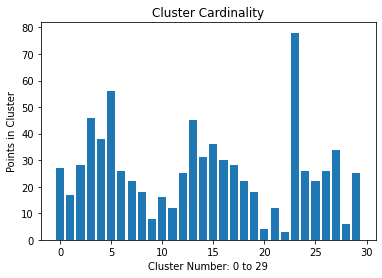

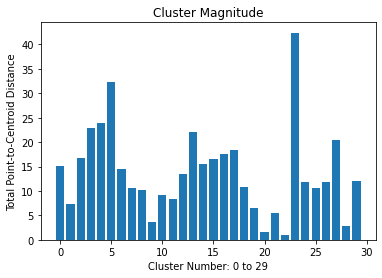

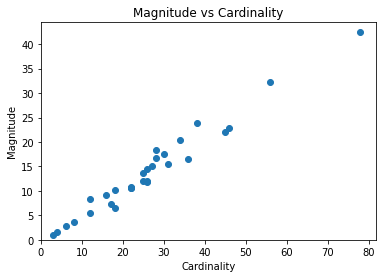

In [57]:
clusterQualityMetrics(choc_data)

## Find Optimum Number of Clusters

You want to find the right number of clusters as you did in the previous
programming exercise. For details, read "*Step Three: Optimum Number of
Clusters*" on the page
[Interpret Results](https://developers.google.com/machine-learning/clustering/interpret).


### Solution: Discussion on optimum number of clusters

In [58]:
# Plot loss vs number of clusters
def lossVsClusters(kmin, kmax, kstep, choc_data):
  kmax += 1  # include kmax-th cluster in range
  kRange = range(kmin, kmax, kstep)
  loss = np.zeros(len(kRange))
  lossCtr = 0
  for kk in kRange:
    [choc_data, centroids] = kmeans(choc_data, kk, feature_cols, 0)
    loss[lossCtr] = np.sum(choc_data['pt2centroid'])
    lossCtr += 1
  plt.scatter(kRange, loss)
  plt.title('Loss vs Clusters Used')
  plt.xlabel('Number of clusters')
  plt.ylabel('Total Point-to-Centroid Distance')


kmin = 5  # @param
kmax = 80  # @param
kstep = 2  # @param
lossVsClusters(kmin, kmax, kstep, choc_data)

SystemExit: 

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## <span style='color:red'> What is the difference between get_dummies, feature_column and LabelEncoder </span>